In [1]:
# Import packages

import numpy as np

import py4DSTEM
print(py4DSTEM.__version__)

import cupy as cp
from matplotlib import pyplot as plt

0.14.9


In [2]:
# User Settings

defocusValInitialGuess = -20000 # Angstroms
iterationTimes = 30

R_pixel = 20.00 # A
SemiConvAngle = 5.1 # [mrad]
AccVoltage = 300e3 # [V]

comRotationForce = -89.0 # [degrees]
comTransposeForce = False

datasetScanSize = (128,128)

batchSize = 1024

In [3]:
# Import the data

phi92_dataset = np.load('/em_data/berk/AllData/data4DSTEM/2023_11_20/Phi92.npz')

dataset = py4DSTEM.DataCube(data = phi92_dataset['data'])
vacuumProbe = phi92_dataset['vacuumProbe']

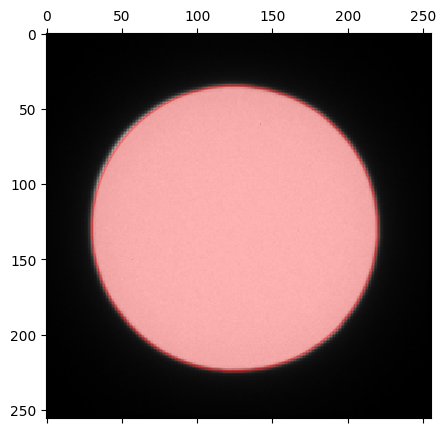

In [4]:
# Get the mean diffraction pattern and set calibrations

dataset.get_dp_mean();
probe_semiangle, probe_qx0, probe_qy0 = py4DSTEM.process.calibration.get_probe_size(
dataset.tree('dp_mean').data)

dataset.calibration.set_R_pixel_size(R_pixel)
dataset.calibration.set_R_pixel_units('A')
dataset.calibration.set_Q_pixel_size(SemiConvAngle / probe_semiangle)
dataset.calibration.set_Q_pixel_units('mrad')

py4DSTEM.visualize.show_circles(
dataset.tree('dp_mean').data, 
(probe_qx0, probe_qy0), 
probe_semiangle)

In [5]:
# Create a cropped dataset, to estimate defocus using parallax

dataset_cropped = py4DSTEM.DataCube(data = phi92_dataset['data'][0:64,:]).bin_Q(2)

dataset_cropped.get_dp_mean();
probe_semiangle_cropped, probe_qx0_cropped, probe_qy0_cropped = py4DSTEM.process.calibration.get_probe_size(
dataset_cropped.tree('dp_mean').data)

dataset_cropped.calibration.set_R_pixel_size(R_pixel)
dataset_cropped.calibration.set_R_pixel_units('A')
dataset_cropped.calibration.set_Q_pixel_size(SemiConvAngle / probe_semiangle_cropped)
dataset_cropped.calibration.set_Q_pixel_units('mrad')

Alignment at bin 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 165.49 image subsets/s]


Rotation of Q w.r.t. R = -89.543 deg
Astigmatism (A1x,A1y)  = (-2,605) Ang
Aberration C1          =  14019 Ang
Defocus dF             = -14019 Ang
Transpose              = False


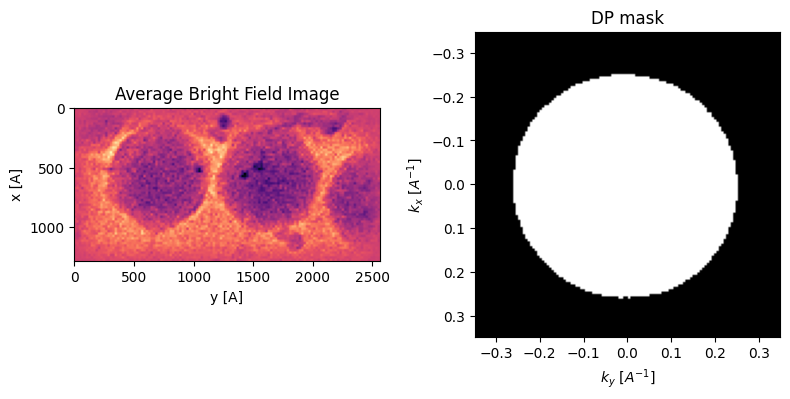

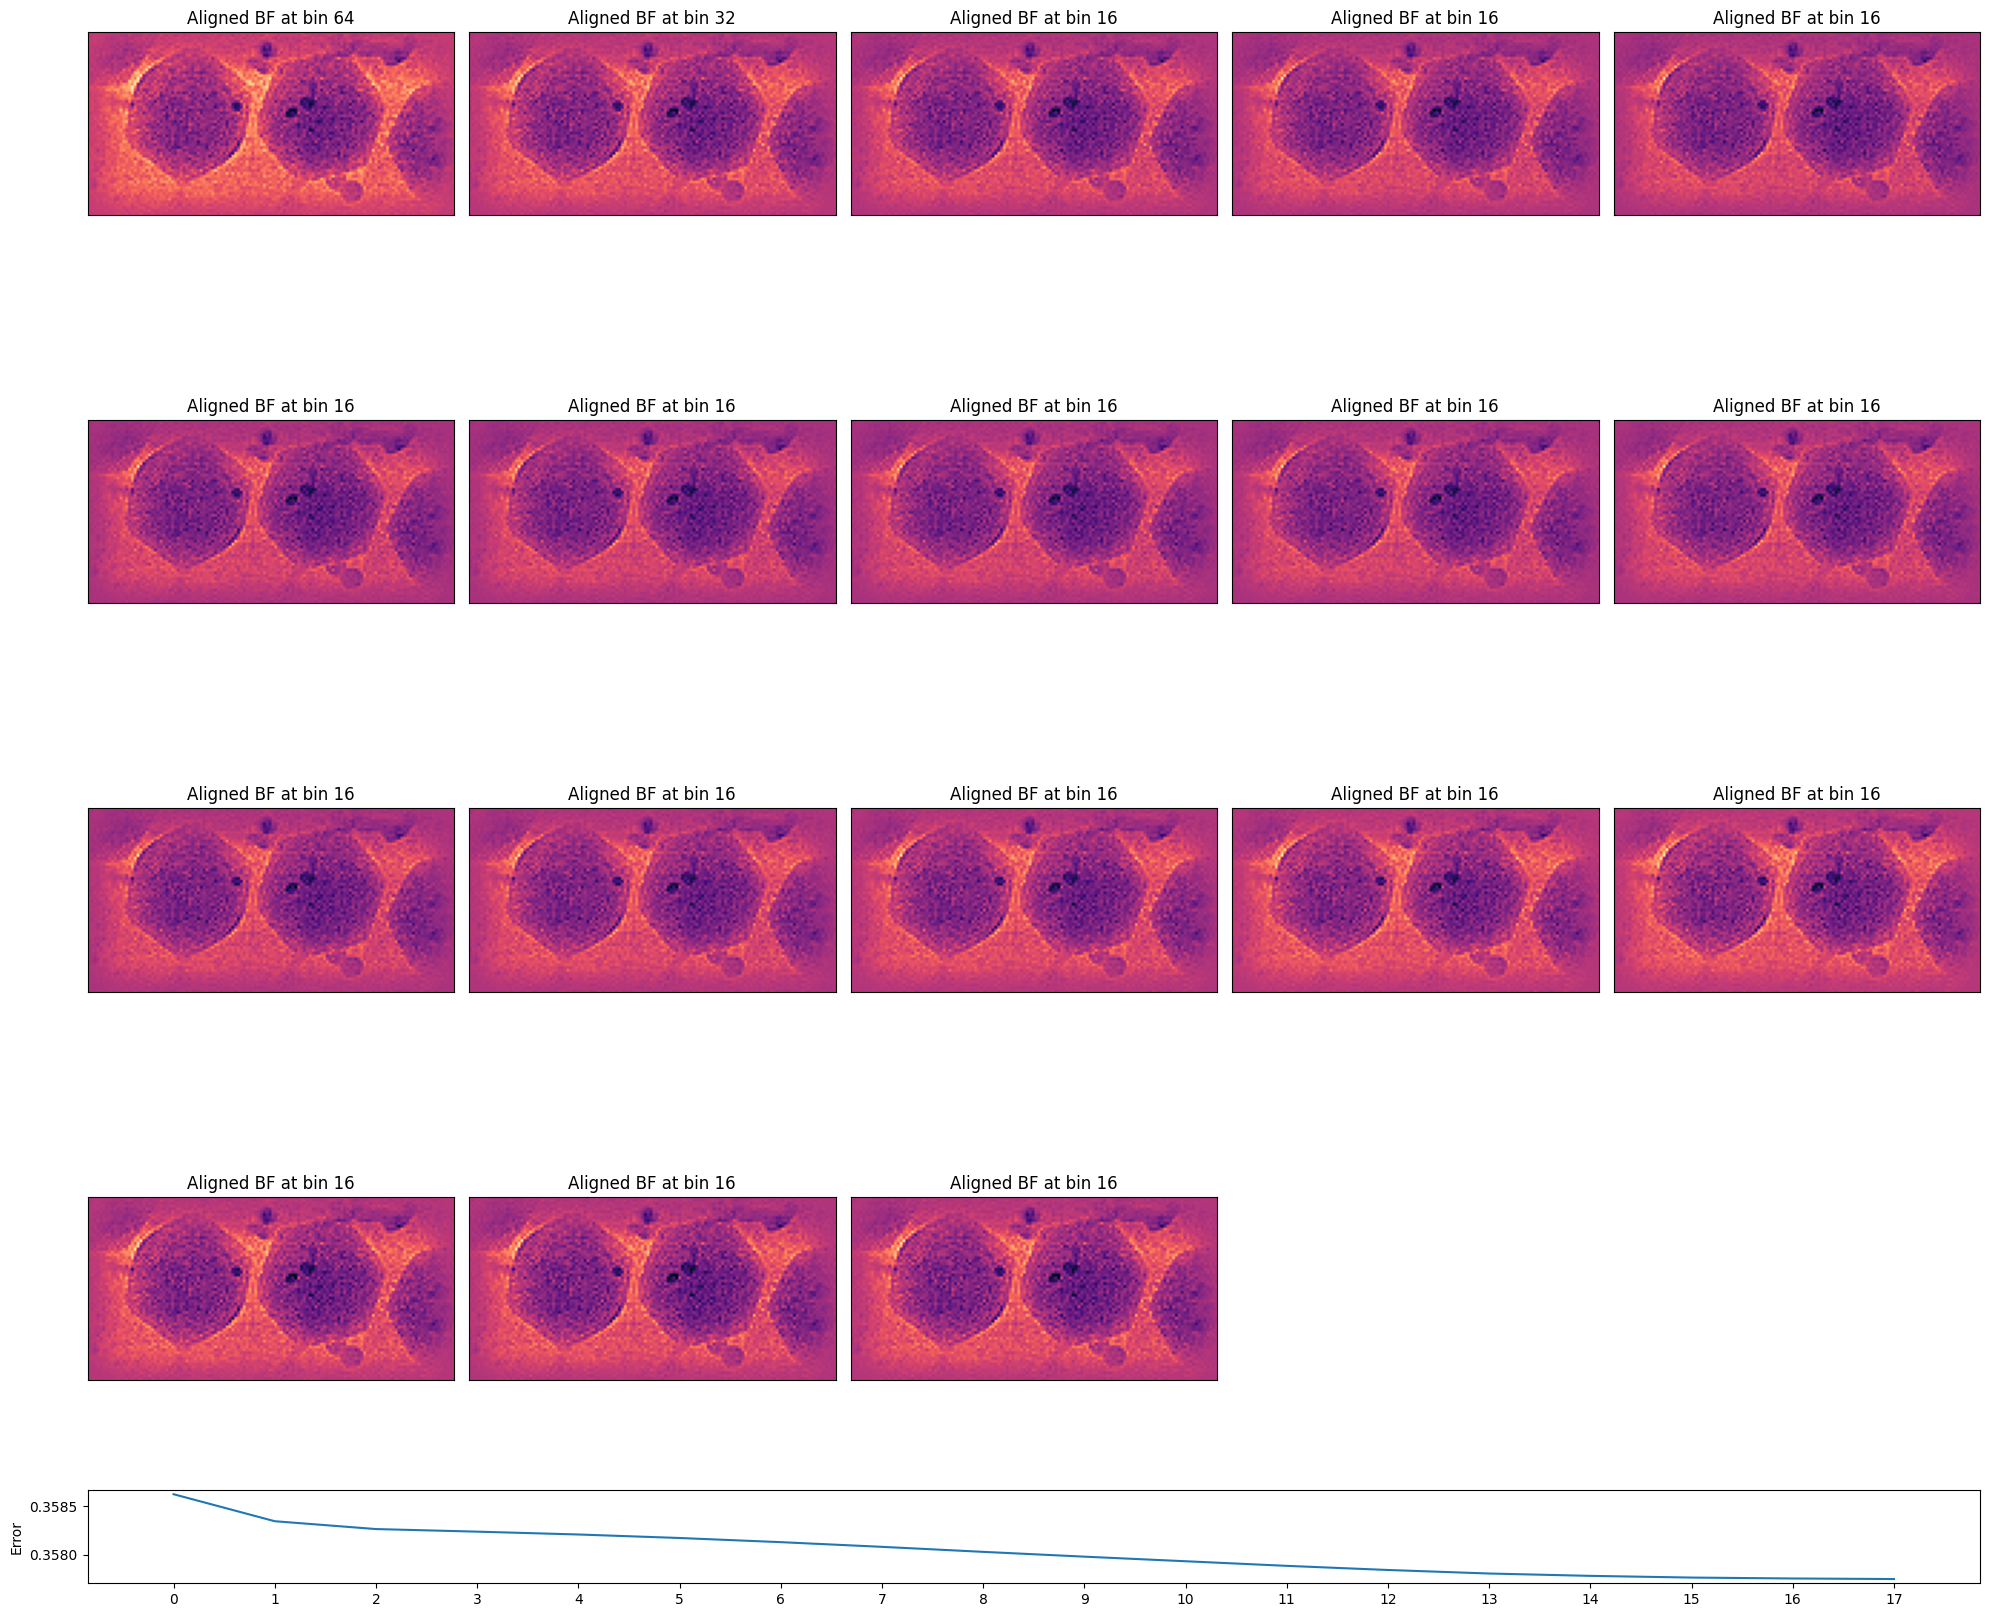

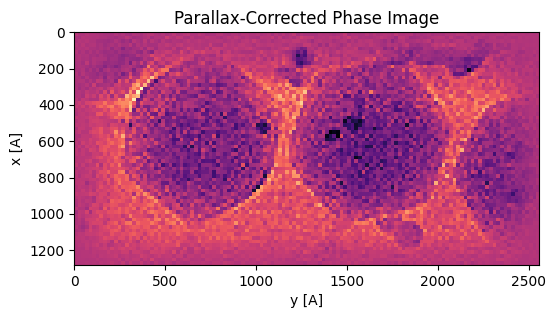

In [6]:
# Parallax, to estimate defocus

parallax = py4DSTEM.process.phase.Parallax(
    energy = 300e3, 
    datacube = dataset_cropped,
    verbose = True,
    device='gpu'
).preprocess(
    defocus_guess= defocusValInitialGuess,
    rotation_guess= comRotationForce
)
parallax.reconstruct(
    min_alignment_bin=16,
    num_iter_at_min_bin=16,
)
parallax.aberration_fit(  
)
parallax.aberration_correct()

Best fit rotation forced to -90 degrees.
Transpose of intensities forced to False.
Performing 30 iterations using a potential object type, with the gradient-descent algorithm, with normalization_min: 1 and step _size: 0.3, in batches of max 1024 measurements.
Reconstructing object and probe: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:09<00:00,  4.33s/ iter]


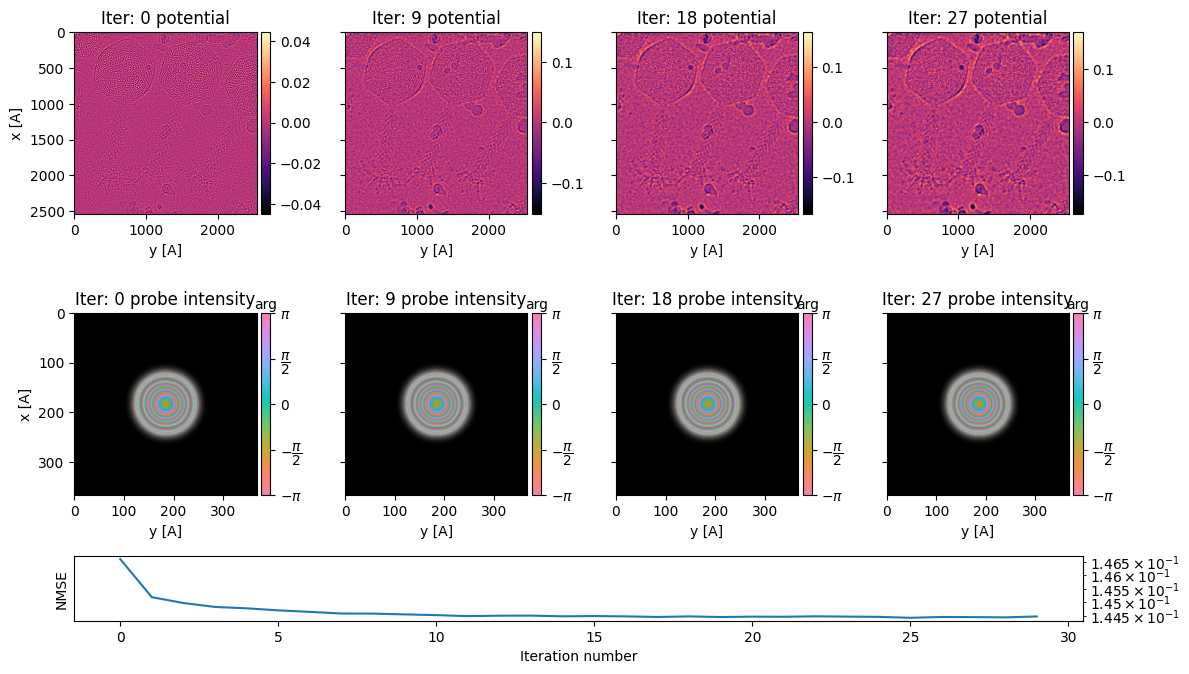

In [7]:
# Single-slice ptychography

ptycho = py4DSTEM.process.phase.SingleslicePtychography(
    verbose=True,
    datacube=dataset,
    device = 'gpu',
    energy = AccVoltage,
    vacuum_probe_intensity = vacuumProbe,
    defocus = -parallax.aberration_C1,
    object_padding_px=(16,16),
    object_type='potential',
).preprocess(
    plot_center_of_mass = False, 
    plot_rotation = False, 
    plot_probe_overlaps = False, 
    force_com_rotation = parallax.rotation_Q_to_R_rads * 180 / np.pi,
    force_com_transpose = comTransposeForce,
)

ptycho = ptycho.reconstruct(
    reset = True,
    store_iterations = True,
    step_size = 0.30,
    num_iter = 30,
    q_lowpass= None,
    fix_positions = True,
    global_affine_transformation = False,
    fix_probe_aperture = True,
    fit_probe_aberrations=True,
    fit_probe_aberrations_max_angular_order = 4,
    fit_probe_aberrations_max_radial_order =  4,
    max_batch_size = batchSize,
    object_positivity=False,
).visualize(
    cbar=True,
    plot_convergence=True,
    plot_probe=True,
    iterations_grid = "auto"
)

Text(0, 0.5, 'X [Angstroms]')

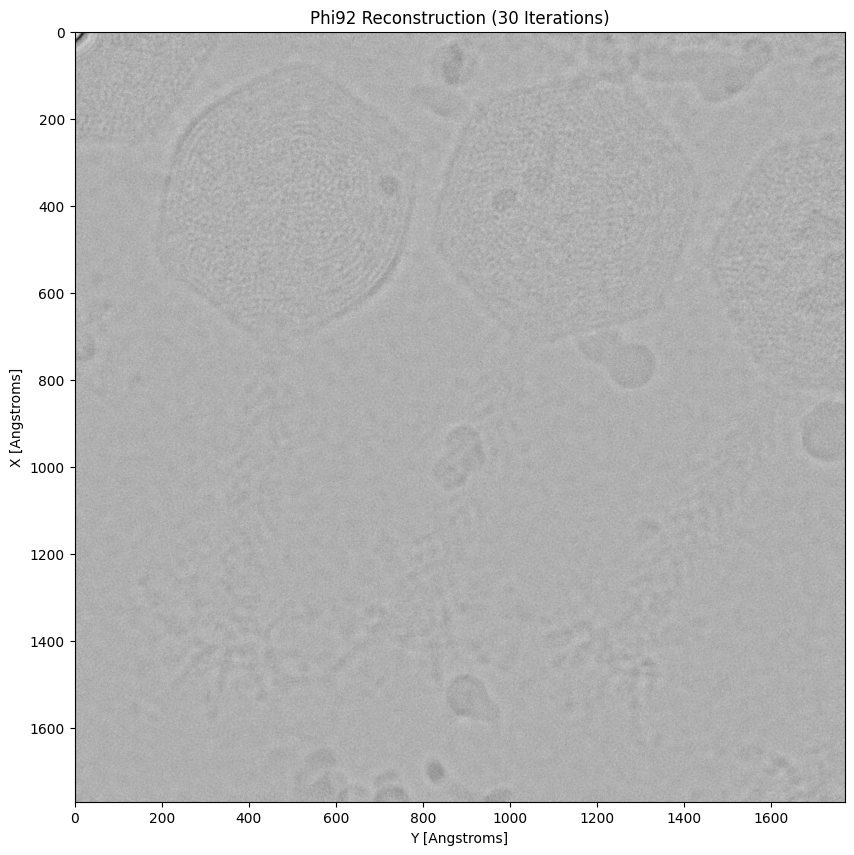

In [8]:
# Plot the result

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(ptycho.object_cropped,cmap='gray')
ax.set_title('Phi92 Reconstruction (30 Iterations)')
ax.set_xlabel('Y [Angstroms]')
ax.set_ylabel('X [Angstroms]')